In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [2]:
def create_MDP1():
    # create the state map
    S = np.arange(10*10).reshape(10,10).T
    
    # create the corresponding reward functions
    R = np.zeros((10,10))
    R[9,9] = 1
    
    return (S,R)

In [3]:
def create_MDP2():
    # create the state map
    S = np.arange(10*10).reshape(10,10).T
    
    # create the corresponding reward functions
    R = np.zeros((10,10))
    R[1:7,4] = -100
    R[3:8,8] = -100
    R[1,5:7] = -100
    R[1:4,6] = -100
    R[3,7] = -100
    R[7:9,6] = -100
    R[7,7] = -100
    R[9,9] = 10

    return (S,R)

In [4]:
def create_heatmap(X,title="Empty"):
    c = plt.pcolor(X,cmap='RdBu',edgecolors='k',linewidths=4)
    plt.gca().invert_yaxis()
    plt.title("Reward 1 Heatmap")
    plt.colorbar()
    plt.show()

In [5]:
def create_rewardmap(X,title="Empty"):
    plt.figure(figsize=(10,10))
    plt.pcolor(np.zeros((10,10)) , cmap='gray',edgecolors='white',linewidth=4)
    for i in np.arange(10):
        for j in np.arange(10):
            plt.text(j+0.5,i+0.5,"{:.3f}".format(float(X[i,j])),color='white',size=10,ha='center', va='center',weight='bold')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.axis('equal')

In [6]:
def create_policymap(policy,title="Empty"):
    plt.figure(figsize=(10,10))
    plt.pcolor(np.zeros((10,10)) , cmap='gray',edgecolors='white',linewidth=4)
    selections = np.array(['\u2190','\u2191','\u2192','\u2193'])
    for i in np.arange(10):
        for j in np.arange(10):
            plt.text(j+0.5,i+0.5,selections[int(policy[i,j])],color='white',size=30,ha='center', va='center',weight='bold')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.axis('equal')

In [7]:
def value_iteration(environment,threshold,discount_factor):
    S = environment.state_space

    V = np.zeros(S.shape); delta = 1
    while delta > threshold:
        delta = 0
        for s in S.ravel():
            x,y = np.where(S==s)
            v = V[x,y]
            Vs = np.zeros((4,))
            for a in np.arange(N_actions):
                states,rewards,p,coordinates = environment.get_transitions(s,a)
                x_,y_ = zip(*coordinates)
                Vs[a] = np.sum(p*(rewards + discount_factor*V[x_,y_]))

            best_action = np.argmax(Vs) 
                
            delta = max(delta,np.abs(Vs[best_action] - v))
            V[x,y] = Vs[best_action]
            
    # compute the optimal policy based on the value iteration
    policy = np.zeros(S.shape)
    for s in S.ravel():
        x,y = np.where(S==s)
        Vs = np.zeros((4,))
        for a in np.arange(N_actions):
            states,rewards,p,coordinates = environment.get_transitions(s,a)
            x_,y_ = zip(*coordinates)
            Vs[a] = np.sum(p*(rewards + discount_factor*V[x_,y_]))

        policy[x,y] = np.argmax(Vs) 

            
    return V,policy

In [8]:
class RL_environment:
    def __init__(self,S,R,A,w):
        self.state_space = S
        self.reward_space = R
        self.N_actions = A
        self.w = w
        
    def step(self,current_state,action):
        x,y = np.where(self.state_space==current_state)
        p = np.array([self.w/4]*self.N_actions)
        p[action] = p[action] + 1-self.w
        
        # action is random to extent ...
        action = np.random.choice(self.N_actions,p=p)
        
        if action == 0:
            y = max(y-1,0)
        elif action == 1:
            x = max(x-1,0)
        elif action == 2:
            y = min(y+1,9)
        else: 
            x = min(x+1,9)
            
        x = int(x); y = int(y)
        return self.state_space[x,y],self.reward_space[x,y]
    
    def get_transitions(self,current_state,action):
        p = np.array([self.w/4]*self.N_actions)
        p[action] = p[action] + 1-self.w
        states = np.zeros((4,))
        rewards = np.zeros((4,))
        coordinates = []
        
        for a in np.arange(self.N_actions):
            
            x,y = np.where(self.state_space==current_state)
            
            if a == 0:
                y = max(y-1,0)
            elif a == 1:
                x = max(x-1,0)
            elif a == 2:
                y = min(y+1,9)
            else: 
                x = min(x+1,9)
                
            x = int(x); y = int(y)
                
            states[a] = self.state_space[x,y]
            rewards[a] = self.reward_space[x,y]
            coordinates.append((x,y))
        return states,rewards,p,coordinates

# PART 1

## Question 1

In [9]:
S1,R1 = create_MDP1()

In [10]:
S2,R2 = create_MDP2()

## Question 2

In [11]:
w = .1
N_actions = 4
discount_factor = 0.8

environment1 = RL_environment(S1,R1,N_actions,w)

In [12]:
threshold = 1e-2; 
V1,policy1 = value_iteration(environment1,threshold,discount_factor)

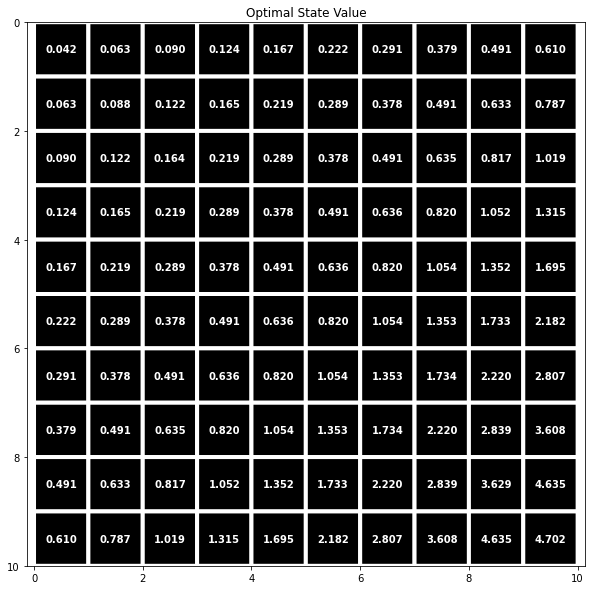

In [13]:
create_rewardmap(V1,"Optimal State Value")

## Question 3

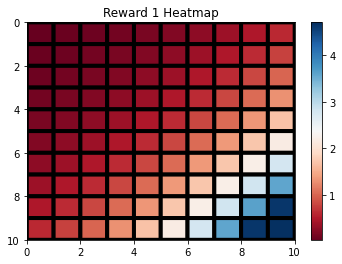

In [14]:
create_heatmap(V1,title="Optimal State Value Heatmap")

## Question 4

C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


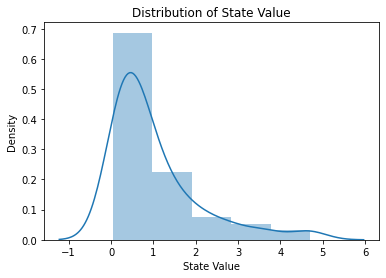

In [15]:
sns.distplot(V1.ravel(),bins=5)
plt.xlabel("State Value"); plt.title("Distribution of State Value");
plt.show()

## Question 5

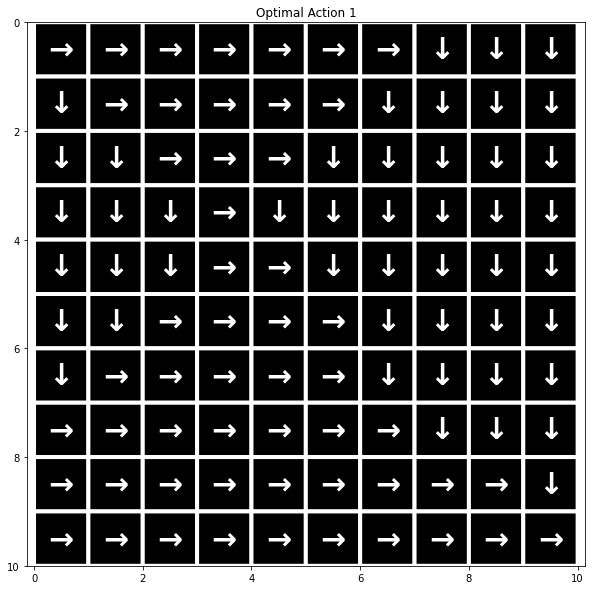

In [16]:
create_policymap(policy1,title="Optimal Action 1")

## Question 6

In [17]:
w = .1
N_actions = 4
discount_factor = 0.8

environment2 = RL_environment(S2,R2,N_actions,w)

In [18]:
threshold = 1e-2
V2,policy2 = value_iteration(environment2,threshold,discount_factor)

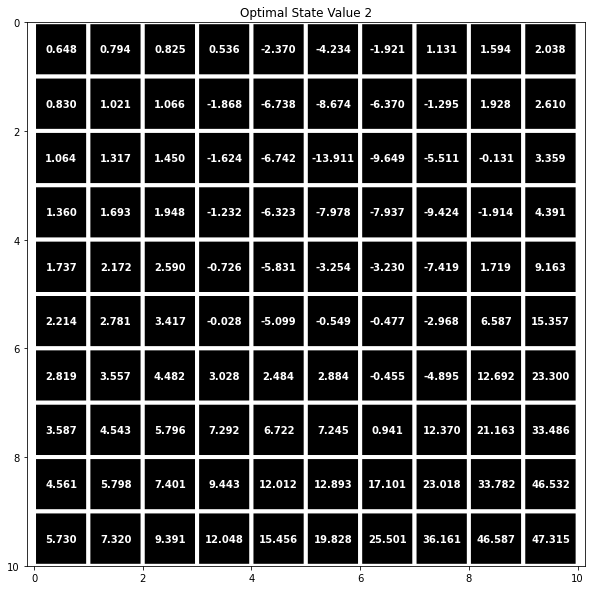

In [19]:
create_rewardmap(V2,title="Optimal State Value 2")

## Question 7

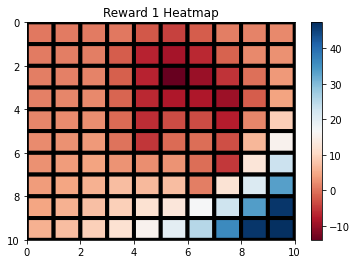

In [20]:
create_heatmap(V2,"Optimal State Value 2 Heatmap")

## Question 8 

C:\Users\lpott\anaconda3\envs\comsci247\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


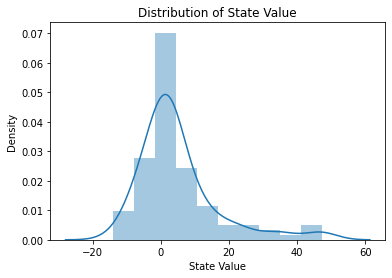

In [21]:
sns.distplot(V2.ravel(),bins=10)
plt.xlabel("State Value"); plt.title("Distribution of State Value");
plt.show()

## Question 9

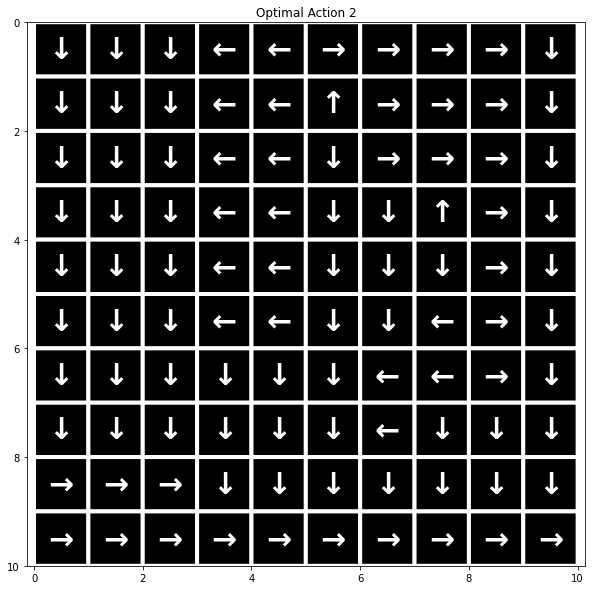

In [22]:
create_policymap(policy2,"Optimal Action 2")

# PART 2